In [1]:
%pylab inline

from library import lasagnennet as LN
from library import features as F
from library import scale as S
from library import validate as V
import numpy as np
import theano as TH
import pandas as pa
import lasagne as L

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: Tesla K20m (CNMeM is disabled)


In [50]:
train_feats = pa.read_csv('win_train_feats.csv')
train_targets = pa.read_csv('win_train_targets.csv')
val_feats = pa.read_csv('win_validation_feats.csv')
val_targets = pa.read_csv('win_validation_targets.csv')
vval_feats = pa.read_csv('win_val_train_feats.csv')
vval_targets = pa.read_csv('win_val_train_targets.csv')

In [3]:
print train_targets.columns

Index([u'ID', u'TIME', u'LABEL', u'ICU'], dtype='object')


In [51]:
tx = np.asarray(train_feats, dtype=np.float32)
tyall = np.asarray(train_targets, dtype=np.float32)
ty = np.asarray(train_targets['LABEL'], dtype=np.float32).reshape(-1, 1)
vx = np.asarray(val_feats, dtype=np.float32)
vyall = np.asarray(val_targets, dtype=np.float32)
vy = np.asarray(val_targets['LABEL'], dtype=np.float32).reshape(-1, 1)

In [52]:
valx = np.asarray(vval_feats, dtype=np.float32)
valyall = np.asarray(vval_targets, dtype=np.int64)

In [54]:
print tx.shape, tyall.shape, ty.shape, vx.shape, vyall.shape, vy.shape, valx.shape, valyall.shape

(486050, 321) (486050, 4) (486050, 1) (142387, 321) (142387, 4) (142387, 1) (199971, 321) (199971, 3)


In [82]:
reload(LN)
nneta = LN.nnet(n_in=321, n_out=1, h_layers=[500,100],
                i_drop=None, l_drops=[0.3,0.3], lam=0.0,
                nonlinearity=L.nonlinearities.sigmoid
           )
nneta.train(x=tx, y=ty, lrate=0.1, gamma=0.9, batch_size=1000, iters=50,
            testx=vx, testy=vy, filename='model.npz'
           )

Training ... 
Iteration 0, Loss = 0.0206610656837
Testing ...
[ 0.88574106  0.88592046  0.88522011 ...,  0.8852005   0.885068    0.88498706]
Mean auc = 0.459337904518
Iteration 1, Loss = 0.0152708733315
Iteration 2, Loss = 0.0145794920532
Iteration 3, Loss = 0.0143362725961
Iteration 4, Loss = 0.0141649310175
Iteration 5, Loss = 0.0140347164698
Iteration 6, Loss = 0.0139371659473
Iteration 7, Loss = 0.0138576877871
Iteration 8, Loss = 0.0137712466138
Iteration 9, Loss = 0.0136811167893
Iteration 10, Loss = 0.0135815620051
Testing ...
[ 0.96063238  0.96051919  0.96037358 ...,  0.96043223  0.96038955
  0.96035987]
Mean auc = 0.852145925555
Iteration 11, Loss = 0.013441315286
Iteration 12, Loss = 0.0132660533338
Iteration 13, Loss = 0.0131100344642


KeyboardInterrupt: 

In [83]:
nneta.loadmodel('model.npz')

In [84]:
probs = nneta.tester(tx)[0].ravel()
vprobs = nneta.tester(vx)[0].ravel()
valprobs = nneta.tester(valx)[0].ravel()
print probs

[ 0.95816541  0.95825428  0.96033973 ...,  0.9599126   0.95994139
  0.95992512]


0.83681590356
0.852145925555


(0.0, 1.0, 0.0, 1.0)

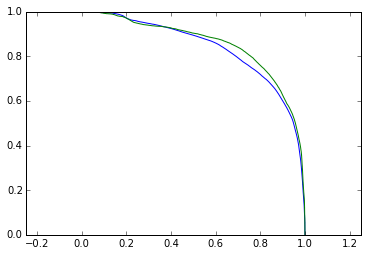

In [85]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

yscore = probs
print roc_auc_score(ty, yscore)
fpr, tpr, thresh = roc_curve(ty, yscore)
pyplot.plot(1-fpr, tpr)
pyplot.axis('equal')

yscore = vprobs
print roc_auc_score(vy, yscore)
fpr, tpr, thresh = roc_curve(vy, yscore)
pyplot.plot(1-fpr, tpr)
pyplot.axis('equal')

In [86]:
thresh = np.percentile(valprobs, 99.5)
pred = np.int32(valprobs >= thresh)
print np.sum(pred)

outfile = open('output.csv', 'w')
# outfile.write('ID,TIME,LABEL\n')
for i in xrange(valx.shape[0]):
    if np.int64(valyall[i,2]) == 1:
        outfile.write(str(valyall[i,0])+','+str(valyall[i,1])+','+str(pred[i])+'\n')
outfile.close()

1001


In [93]:
thresh = np.percentile(vprobs.ravel(), 98.3)
pred = np.int32(vprobs.ravel() >= thresh)
print np.sum(pred)

outfile = open('out.csv', 'w')
outfile.write('ID,TIME,LABEL,ICU\n')
for i in xrange(vx.shape[0]):
    if np.int32(vyall[i,3]) == 1.0:
        outfile.write(str(vyall[i,0])+','+str(vyall[i,1])+','+str(pred[i])+',1\n')
outfile.close()

2421


In [94]:
reload(V)
V.validate('out.csv', './Training_Dataset/id_label_train.csv')

tp :  22 , tn :  824 , fp :  7 , fn :  47
sensitivity :  0.31884057971 , specificity :  0.991576413959
accuracy :  0.94 median prediction time :  80.065
finalScore :  44.7012504578


(0.3188405797101449,
 0.9915764139590855,
 0.94,
 80.064999999999998,
 44.7012504578036)